In [1]:
import time
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import utils, datasets, transforms
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import torch.nn.functional as F
from torchvision.models import inception_v3
from torch.utils.data import DataLoader, TensorDataset
from scipy.stats import entropy
from torchmetrics.image.fid import FrechetInceptionDistance
import numpy as np


# Set random seed for reproducibility
torch.manual_seed(0)

In [2]:
device = torch.device('cuda:1' if (torch.cuda.is_available() and 1 > 0) else 'cpu')

# Batch size during training
BATCH_SIZE = 64

# Spatial size of training images. All images will be resized to this size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Number of classes in the training images. For mnist dataset this is 10
num_classes = 10

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 100

# Learning rate for optimizers
lr = 0.001

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

ngpu = 1

In [3]:
image_directory = 'data-students\\TRAIN'

transform = transforms.Compose([transforms.Resize([64, 64]),
                                transforms.ToTensor(),
                                transforms.Normalize([0.5], [0.5])])


train_dataset = datasets.ImageFolder(root=image_directory, transform=transform)

print(train_dataset)


data_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

print(data_loader)

#show labels of the dataset

print(train_dataset.classes)
print(len(train_dataset.classes))


Dataset ImageFolder
    Number of datapoints: 277
    Root location: data-students\TRAIN
    StandardTransform
Transform: Compose(
               Resize(size=[64, 64], interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=[0.5], std=[0.5])
           )
['12', '13', '24', '38', '39', '44', '46', '49', '50', '6']
10


## Images

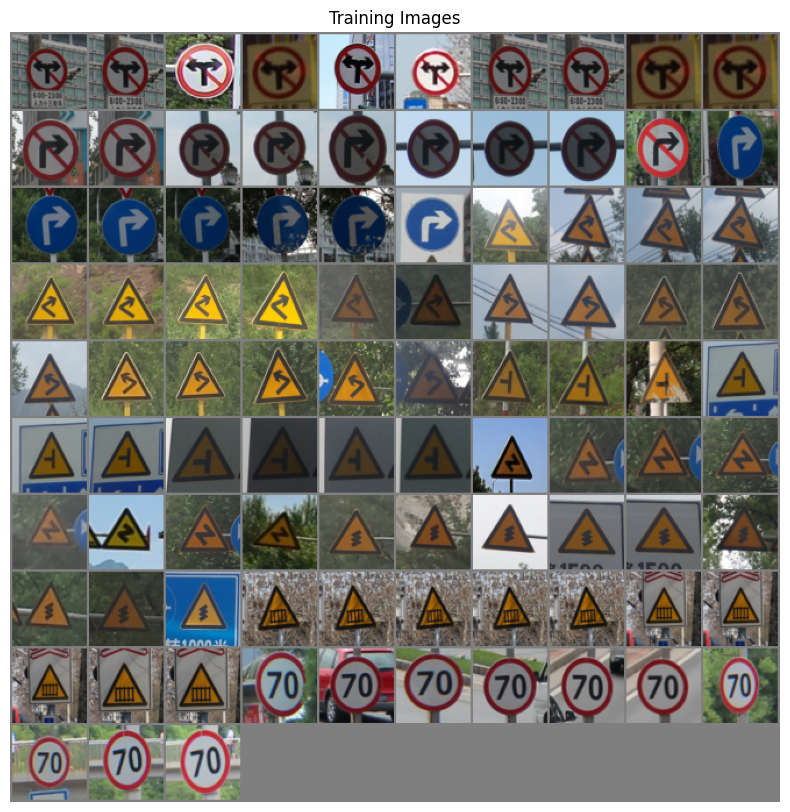

In [4]:
imgs = {}
for x, y in train_dataset:
    if y not in imgs:
        imgs[y] = []
    elif len(imgs[y])!=10:
        imgs[y].append(x)
    elif sum(len(imgs[key]) for key in imgs)==100:
        break
    else:
        continue
        
imgs = sorted(imgs.items(), key=lambda x:x[0])
imgs = [torch.stack(item[1], dim=0) for item in imgs]
imgs = torch.cat(imgs, dim=0)

plt.figure(figsize=(10,10))
plt.title("Training Images")
plt.axis('off')
imgs = utils.make_grid(imgs, nrow=10)
plt.imshow(imgs.permute(1, 2, 0)*0.5+0.5)

In [5]:
# Inicializar pesos

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


## Generator

In [6]:
# self, channel, out_channel, kernel_size, stride, padding

class Generator(nn.Module):
    def __init__(self, ngpu, nz, ngf, num_classes, nc):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.image = nn.Sequential(
            # state size. (nz) x 1 x 1
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True)
            # state size. (ngf*8) x 4 x 4
        )
        self.label = nn.Sequential(
            # state size. (num_classes) x 1 x 1
            nn.ConvTranspose2d(num_classes, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True)
            # state size. (ngf*8) x 4 x 4
        )
        self.main = nn.Sequential(
            # state size. (ngf*16) x 4 x 4
            nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 8 x 8
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 16 x 16
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 32 x 32
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 64 x 64
            nn.ConvTranspose2d(ngf, nc, 1, 1, 0, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, noise, labels):
        image = self.image(noise)
        label = self.label(labels)
        incat = torch.cat((image, label), dim=1)
        return self.main(incat)


In [7]:
netG = Generator(ngpu, nz, ngf, num_classes, nc).to(device)

# Handle multi-gpu if desired
if device.type == 'cuda' and 1 > 1:
    netG = nn.DataParallel(netG, list(range(1)))

# Apply the weights_init function to randomly initialize all weights to mean=0, stdev=0.2.
netG.apply(weights_init)

Generator(
  (image): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (label): Sequential(
    (0): ConvTranspose2d(10, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (main): Sequential(
    (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1,

## Descriminator

In [8]:
class Discriminator(nn.Module):
    def __init__(self, ngpu, ndf, num_classes, nc):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.image = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True)
            # state size. (ndf) x 32 x 32
        )
        self.label = nn.Sequential(
            # input is (num_classes) x 64 x 64
            nn.Conv2d(num_classes, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True)
            # state size. (ndf) x 32 x 32
        )
        self.main = nn.Sequential(
            # state size. (ndf*2) x 32 x 32
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 16 x 16
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 8 x 8
            nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*16) x 4 x 4
            nn.Conv2d(ndf * 16, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
            # state size. (1) x 1 x 1
        )

    def forward(self, image, label):
        image = self.image(image)
        label = self.label(label)
        incat = torch.cat((image, label), dim=1)
        return self.main(incat)


In [9]:
# Create the discriminator
netD = Discriminator(ngpu, ndf, num_classes, nc).to(device)

# Handle multi-gpu if desired
if device.type == 'cuda' and 1 > 1:
    netD = nn.DataParallel(netD, list(range(1)))

# Apply the weights_init function to randomly initialize all weights to mean=0, stdev=0.2.
netD.apply(weights_init)

Discriminator(
  (image): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (label): Sequential(
    (0): Conv2d(10, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (main): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_runni

In [10]:
# Instantiate Generator and Discriminator
generator = Generator(ngpu, nz, ngf, num_classes, nc).to(device)
discriminator = Discriminator(ngpu, ndf, num_classes, nc).to(device)

# Create an example tensor for the Generator
noise = torch.randn(BATCH_SIZE, nz, 1, 1, device=device)
labels = torch.randint(0, num_classes, (BATCH_SIZE,), device=device)
labels_one_hot = F.one_hot(labels, num_classes).float().view(BATCH_SIZE, num_classes, 1, 1).to(device)

# Generate a fake image
fake_images = generator(noise, labels_one_hot)

# Test the Discriminator with the generated image
# Expand the labels to the size of the image
labels_expanded = F.one_hot(labels, num_classes).float().unsqueeze(2).unsqueeze(3).expand(BATCH_SIZE, num_classes, 64, 64).to(device)

print("Fake images shape:", fake_images.shape)

discriminator_output = discriminator(fake_images, labels_expanded)

# Output the results
print("Fake images shape:", fake_images.shape)  # Expected: [BATCH_SIZE, nc, 64, 64]
print("Discriminator output shape:", discriminator_output.shape)  # Expected: [BATCH_SIZE, 1, 1, 1]


Fake images shape: torch.Size([64, 3, 64, 64])
Fake images shape: torch.Size([64, 3, 64, 64])
Discriminator output shape: torch.Size([64, 1, 1, 1])


## Optimizer and Loss Function

In [11]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Establish convention for real and fake labels during training
real_label_num = 0.9
fake_label_num = 0.1

# Setup Adam optimizers for both G and D
optimizerD = torch.optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# Label one-hot for G
label_1hots = torch.zeros(10,10)
for i in range(10):
    label_1hots[i,i] = 1
label_1hots = label_1hots.view(10,10,1,1).to(device)

# Label one-hot for D
label_fills = torch.zeros(10, 10, image_size, image_size)
ones = torch.ones(image_size, image_size)
for i in range(10):
    label_fills[i][i] = ones
label_fills = label_fills.to(device)

# Create batch of latent vectors and laebls that we will use to visualize the progression of the generator
fixed_noise = torch.randn(100, nz, 1, 1).to(device)
fixed_label = label_1hots[torch.arange(10).repeat(10).sort().values]

## Train

In [12]:
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
D_x_list = []
D_z_list = []
loss_tep = 10

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):

    beg_time = time.time()
    # For each batch in the dataloader
    for i, data in enumerate(data_loader):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        
        # Format batch
        real_image = data[0].to(device)
        b_size = real_image.size(0)

        real_label = torch.full((b_size,), real_label_num).to(device)
        fake_label = torch.full((b_size,), fake_label_num).to(device)
        
        G_label = label_1hots[data[1]]
        D_label = label_fills[data[1]]
        
        # Forward pass real batch through D
        output = netD(real_image, D_label).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, real_label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1).to(device)
        # Generate fake image batch with G
        fake = netG(noise, G_label)
        # Classify all fake batch with D
        output = netD(fake.detach(), D_label).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, fake_label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake, D_label).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, real_label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        end_time = time.time()
        run_time = round(end_time-beg_time)
        print(
            f'Epoch: [{epoch+1:0>{len(str(num_epochs))}}/{num_epochs}]',
            f'Step: [{i+1:0>{len(str(len(data_loader)))}}/{len(data_loader)}]',
            f'Loss-D: {errD.item():.4f}',
            f'Loss-G: {errG.item():.4f}',
            f'D(x): {D_x:.4f}',
            f'D(G(z)): [{D_G_z1:.4f}/{D_G_z2:.4f}]',
            f'Time: {run_time}s',
            end='\n'
        )

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Save D(X) and D(G(z)) for plotting later
        D_x_list.append(D_x)
        D_z_list.append(D_G_z2)
        
        # Save the Best Model
        if errG < loss_tep:
            torch.save(netG.state_dict(), 'model.pt')
            loss_tep = errG

    # Check how the generator is doing by saving G's output on fixed_noise and fixed_label
    with torch.no_grad():
        fake = netG(fixed_noise, fixed_label).detach().cpu()
    img_list.append(utils.make_grid(fake, nrow=10))


Starting Training Loop...
Epoch: [001/100] Step: [1/5] Loss-D: 2.0214 Loss-G: 25.5194 D(x): 0.6457 D(G(z)): [0.6801/0.1873] Time: 5s
Epoch: [001/100] Step: [2/5] Loss-D: 18.2370 Loss-G: 20.9495 D(x): 0.2766 D(G(z)): [0.3344/0.4389] Time: 8s
Epoch: [001/100] Step: [3/5] Loss-D: 37.3287 Loss-G: 23.1385 D(x): 0.5500 D(G(z)): [0.5071/0.2104] Time: 10s
Epoch: [001/100] Step: [4/5] Loss-D: 25.7266 Loss-G: 13.1896 D(x): 0.3366 D(G(z)): [0.2861/0.2069] Time: 12s
Epoch: [001/100] Step: [5/5] Loss-D: 49.0435 Loss-G: 11.7816 D(x): 0.4046 D(G(z)): [0.6377/0.6667] Time: 13s
Epoch: [002/100] Step: [1/5] Loss-D: 67.2637 Loss-G: 11.8766 D(x): 0.5448 D(G(z)): [0.9217/0.5994] Time: 5s
Epoch: [002/100] Step: [2/5] Loss-D: 41.1258 Loss-G: 14.1061 D(x): 0.6922 D(G(z)): [0.5460/0.3438] Time: 7s
Epoch: [002/100] Step: [3/5] Loss-D: 34.9862 Loss-G: 4.2726 D(x): 0.4306 D(G(z)): [0.2875/0.9268] Time: 9s
Epoch: [002/100] Step: [4/5] Loss-D: 43.7945 Loss-G: 5.8839 D(x): 0.9128 D(G(z)): [0.9619/0.4278] Time: 12s
E

## Métricas

In [13]:
# Função para calcular Inception Score
def inception_score(imgs, device, batch_size=32, resize=True, splits=10):
    N = len(imgs)
    
    # Inception v3 model
    inception_model = inception_v3(pretrained=True, transform_input=False).to(device)
    inception_model.eval()
    
    def get_pred(x):
        if resize:
            x = F.interpolate(x, size=(299, 299), mode='bilinear', align_corners=False)
        x = inception_model(x)
        return F.softmax(x, dim=1).data.cpu().numpy()

    preds = np.zeros((N, 1000))

    dataloader = DataLoader(TensorDataset(imgs), batch_size=batch_size)

    for i, batch in enumerate(dataloader, 0):
        batch = batch[0].to(device)
        batch_size_i = batch.size()[0]

        preds[i*batch_size:i*batch_size + batch_size_i] = get_pred(batch)

    split_scores = []

    for k in range(splits):
        part = preds[k * (N // splits): (k+1) * (N // splits), :]
        py = np.mean(part, axis=0)
        scores = []
        for i in range(part.shape[0]):
            pyx = part[i, :]
            scores.append(entropy(pyx, py))
        split_scores.append(np.exp(np.mean(scores)))

    return np.mean(split_scores), np.std(split_scores)


In [14]:
# Função para gerar imagens usando o gerador treinado da DBCGAN
def generate_images(generator, num_images, z_dim, num_classes, device):
    generator.eval()
    z = torch.randn(num_images, z_dim, 1, 1).to(device)
    labels = torch.randint(0, num_classes, (num_images,)).to(device)
    G_label = label_1hots[labels]
    with torch.no_grad():
        images = generator(z, G_label)
    return images

# Configurações
num_images = 100  # Número de imagens a serem geradas
z_dim = 100
num_classes = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Gerar as imagens
images = generate_images(netG, num_images, z_dim, num_classes, device)

# Calcular o Inception Score
mean, std = inception_score(images, device)
print(f"Inception Score: {mean} ± {std}")

#################################################################

# Gerar as imagens
generated_images = generate_images(netG, num_images, z_dim, num_classes, device)

# Carregar imagens reais do DataLoader
real_images = []
for i, (data, _) in enumerate(data_loader):
    real_images.append(data)
    if len(real_images) * data.shape[0] >= num_images:
        break

real_images = torch.cat(real_images, dim=0)[:num_images]

# Converta as imagens para uint8
real_images = (real_images * 255).byte()
generated_images = (generated_images * 255).byte()

# Mover para o dispositivo (GPU/CPU)
real_images = real_images.to(device)
generated_images = generated_images.to(device)

# Preparar o objeto FID
fid = FrechetInceptionDistance(feature=2048).to(device)
# Calcular FID
fid.update(real_images, real=True)
fid.update(generated_images, real=False)

fid_score = fid.compute()
print(f'FID Score: {fid_score.item()}')

c:\Users\Ze\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Ze\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inception Score: 1.0812747261533884 ± 0.029394105224970952
FID Score: 291.7962341308594


## Real vs Fake

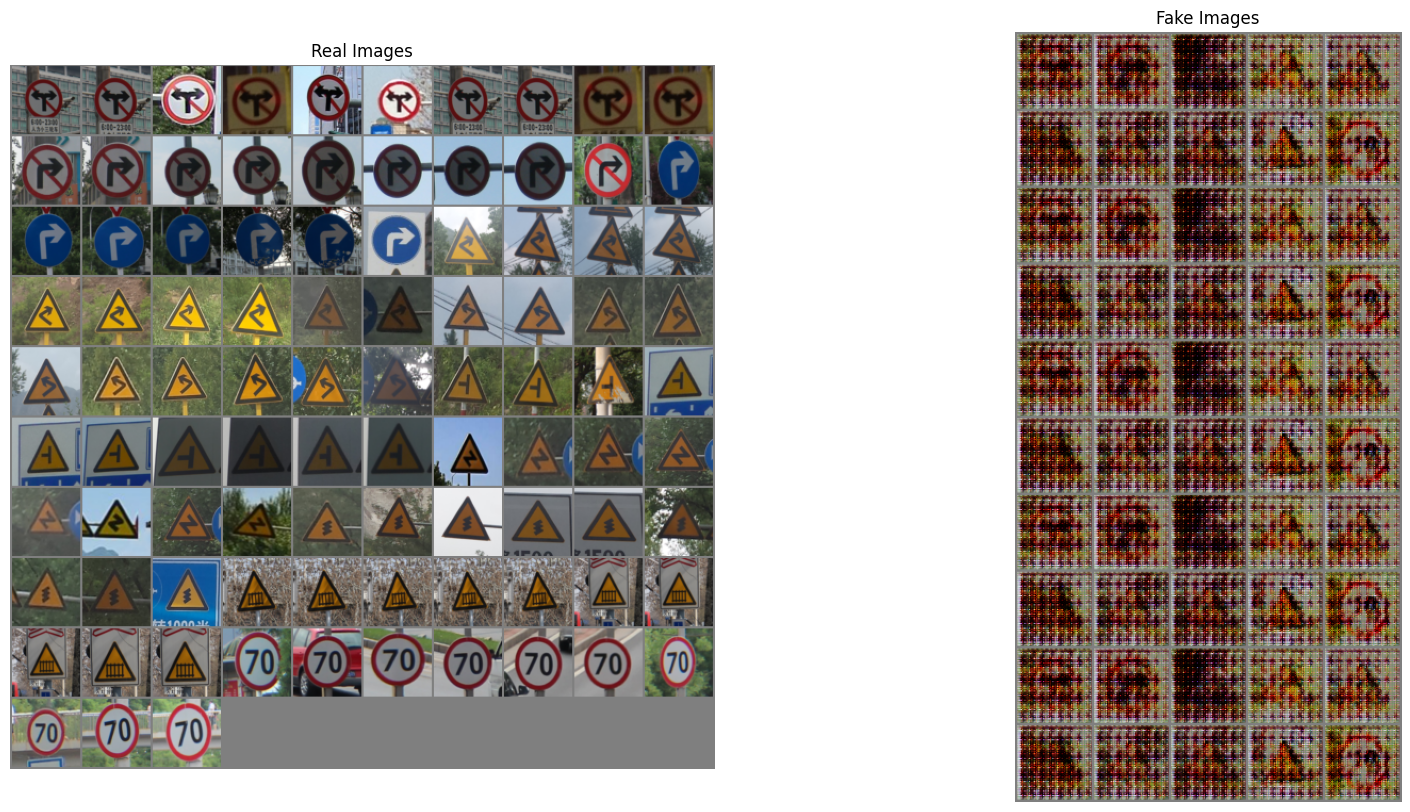

In [15]:
# Define fixed noise and label for generating fake images
num_images_per_class = 5
total_images = num_classes * num_images_per_class

fixed_noise = torch.randn(total_images, nz, 1, 1, device=device)
fixed_label = torch.zeros(total_images, num_classes, 1, 1, device=device)
for i in range(total_images):
    fixed_label[i, i % num_classes] = 1  # One-hot encoding para os rótulos

# Carrega o melhor modelo gerador
netG.load_state_dict(torch.load('model.pt', map_location=device))
netG.eval()

# Gerar as imagens falsas
with torch.no_grad():
    fake = netG(fixed_noise, fixed_label)

# Plotar as imagens reais (assumindo que `imgs` está definido em outro lugar e tem 3 canais de cor)
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.axis('off')
plt.title("Real Images")
imgs = utils.make_grid(imgs, nrow=10)
plt.imshow(imgs.permute(1, 2, 0) * 0.5 + 0.5)  # Converter de [-1, 1] para [0, 1]

# Plotar as imagens falsas
plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Fake Images")
fake = utils.make_grid(fake, nrow=num_images_per_class)
plt.imshow(fake.permute(1, 2, 0) * 0.5 + 0.5)  # Converter de [-1, 1] para [0, 1]

# Salvar o resultado da comparação
plt.savefig('result.jpg', bbox_inches='tight')
plt.show()